# 네이버 영화리뷰 감성분석 도전하기

## Naver sentiment movie corpus 데이터 연결
---

In [1]:
! ln -s ~/data/*.txt ~/aiffel/NLP/sentiment_classification/data

ln: failed to create symbolic link '/aiffel/aiffel/NLP/sentiment_classification/data/ratings_test.txt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/NLP/sentiment_classification/data/ratings_train.txt': File exists


## 사용할 라이브러리 버전 확인
---

In [2]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 1) 데이터 준비와 확인
---

In [3]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/NLP/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/NLP/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


<AxesSubplot:>

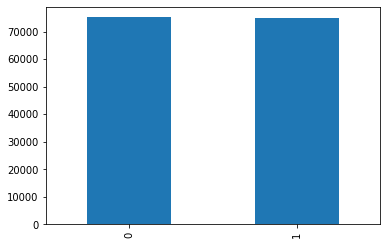

In [4]:
train_data['label'].value_counts().plot(kind = 'bar')

## 2) 데이터로더 구성
---

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [5]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words - 4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [6]:
len(word_to_index)

10000

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공
---
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

### 데이터셋 내 문장 길이 분포
---

In [9]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


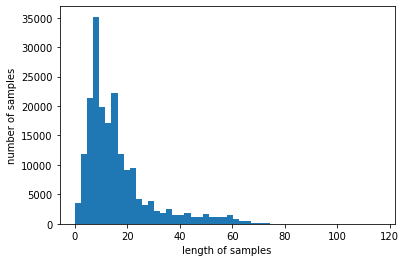

In [10]:
import matplotlib.pyplot as plt

plt.hist([len(tokens) for tokens in total_data_text], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 적절한 최대 문장 길이 지정
---

In [11]:
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

pad_sequences maxlen :  54
전체 문장의 0.9720946661956905%가 maxlen 설정값 이내에 포함됩니다. 


### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
---

In [12]:
import tensorflow as tf

# padding = 'pre'(앞쪽)
X_train_pre = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test_pre = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train_pre.shape)

(146182, 54)


## 4) 모델 구성 및 validation set 구성
---

### validation set 구성

In [13]:
# validation set 10000건 분리
x_val = X_train_pre[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train_pre[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 54)
(136182,)


### RNN 모델 구성

In [14]:
vocab_size = len(word_to_index)  
word_vector_dim = 100

rnn_model = tf.keras.Sequential()
rnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_model.add(tf.keras.layers.LSTM(100))  
rnn_model.add(tf.keras.layers.Dropout(0.8))  # Dropout 추가
rnn_model.add(tf.keras.layers.Dense(64, activation='relu'))
rnn_model.add(tf.keras.layers.Dropout(0.8))  # Dropout 추가
rnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,086,929
Trainable params: 1,086,929
Non-trainable params: 0
______________________________________________

### CNN 모델 구성

In [15]:
vocab_size = len(word_to_index)  
word_vector_dim = 100

cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(tf.keras.layers.Conv1D(64, 5, activation='relu'))
cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_model.add(tf.keras.layers.Dense(32, activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(0.7))  # 드롭아웃 적용
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,034,177
Trainable params: 1,034,177
Non-trainable params: 0
____________________________________________

### GlobalMaxPooling 만 있는 모델

In [16]:
vocab_size = len(word_to_index)  
word_vector_dim = 100

gmp_model = tf.keras.Sequential()
gmp_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmp_model.add(tf.keras.layers.GlobalMaxPooling1D())
gmp_model.add(tf.keras.layers.Dropout(0.7))  # 드롭아웃 레이어 추가
gmp_model.add(tf.keras.layers.Dense(64, activation='relu'))
gmp_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gmp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,006,529
Trainable params: 1,006,529
Non-trainable params: 0
_________________________________________________________________


## 5) 모델 훈련 개시

### RNN

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rnn_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              

from keras.callbacks import EarlyStopping, LearningRateScheduler

epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5) 

rnn_history = rnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stop],  
                    verbose=1)

Epoch 1/30
266/266 [==============================] - 7s 13ms/step - loss: 0.4659 - accuracy: 0.7829 - val_loss: 0.3414 - val_accuracy: 0.8544
Epoch 2/30
266/266 [==============================] - 3s 11ms/step - loss: 0.3507 - accuracy: 0.8588 - val_loss: 0.3336 - val_accuracy: 0.8533
Epoch 3/30
266/266 [==============================] - 3s 11ms/step - loss: 0.3195 - accuracy: 0.8729 - val_loss: 0.3277 - val_accuracy: 0.8578
Epoch 4/30
266/266 [==============================] - 3s 11ms/step - loss: 0.2917 - accuracy: 0.8856 - val_loss: 0.3356 - val_accuracy: 0.8604
Epoch 5/30
266/266 [==============================] - 3s 11ms/step - loss: 0.2695 - accuracy: 0.8950 - val_loss: 0.3410 - val_accuracy: 0.8549
Epoch 6/30
266/266 [==============================] - 3s 11ms/step - loss: 0.2478 - accuracy: 0.9039 - val_loss: 0.3719 - val_accuracy: 0.8567
Epoch 7/30
266/266 [==============================] - 3s 11ms/step - loss: 0.2320 - accuracy: 0.9098 - val_loss: 0.3953 - val_accuracy: 0.8538

In [18]:
rnn_history_dict = rnn_history.history
print(rnn_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### CNN

In [19]:
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              

from keras.callbacks import EarlyStopping

epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5) 

cnn_history = cnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stop],  # EarlyStopping 콜백 적용
                    verbose=1)

Epoch 1/30
266/266 [==============================] - 4s 8ms/step - loss: 0.4809 - accuracy: 0.7713 - val_loss: 0.3408 - val_accuracy: 0.8515
Epoch 2/30
266/266 [==============================] - 2s 6ms/step - loss: 0.3485 - accuracy: 0.8620 - val_loss: 0.3215 - val_accuracy: 0.8601
Epoch 3/30
266/266 [==============================] - 2s 6ms/step - loss: 0.3041 - accuracy: 0.8845 - val_loss: 0.3220 - val_accuracy: 0.8640
Epoch 4/30
266/266 [==============================] - 2s 6ms/step - loss: 0.2616 - accuracy: 0.9048 - val_loss: 0.3328 - val_accuracy: 0.8598
Epoch 5/30
266/266 [==============================] - 2s 6ms/step - loss: 0.2145 - accuracy: 0.9257 - val_loss: 0.3736 - val_accuracy: 0.8612
Epoch 6/30
266/266 [==============================] - 2s 6ms/step - loss: 0.1687 - accuracy: 0.9440 - val_loss: 0.4144 - val_accuracy: 0.8598
Epoch 7/30
266/266 [==============================] - 2s 6ms/step - loss: 0.1313 - accuracy: 0.9577 - val_loss: 0.4861 - val_accuracy: 0.8560


### GMP

In [20]:
gmp_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              

from keras.callbacks import EarlyStopping

epochs=30
early_stop = EarlyStopping(monitor='val_loss', patience=5) 

gmp_history = gmp_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stop],  # EarlyStopping 콜백 적용
                    verbose=1)

Epoch 1/30
266/266 [==============================] - 2s 4ms/step - loss: 0.5400 - accuracy: 0.7222 - val_loss: 0.3721 - val_accuracy: 0.8384
Epoch 2/30
266/266 [==============================] - 1s 4ms/step - loss: 0.4115 - accuracy: 0.8158 - val_loss: 0.3485 - val_accuracy: 0.8464
Epoch 3/30
266/266 [==============================] - 1s 4ms/step - loss: 0.3776 - accuracy: 0.8346 - val_loss: 0.3424 - val_accuracy: 0.8488
Epoch 4/30
266/266 [==============================] - 1s 4ms/step - loss: 0.3571 - accuracy: 0.8460 - val_loss: 0.3438 - val_accuracy: 0.8502
Epoch 5/30
266/266 [==============================] - 1s 4ms/step - loss: 0.3456 - accuracy: 0.8511 - val_loss: 0.3441 - val_accuracy: 0.8506
Epoch 6/30
266/266 [==============================] - 1s 4ms/step - loss: 0.3332 - accuracy: 0.8568 - val_loss: 0.3431 - val_accuracy: 0.8516
Epoch 7/30
266/266 [==============================] - 1s 4ms/step - loss: 0.3284 - accuracy: 0.8592 - val_loss: 0.3447 - val_accuracy: 0.8506
Epoch 

## 6) Loss, Accuracy 그래프 시각화

### RNN

In [21]:
rnn_history_dict = rnn_history.history
print(rnn_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


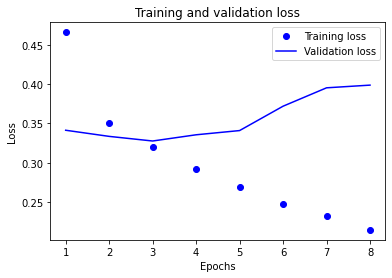

In [22]:
import matplotlib.pyplot as plt

acc = rnn_history_dict['accuracy']
val_acc = rnn_history_dict['val_accuracy']
loss = rnn_history_dict['loss']
val_loss = rnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

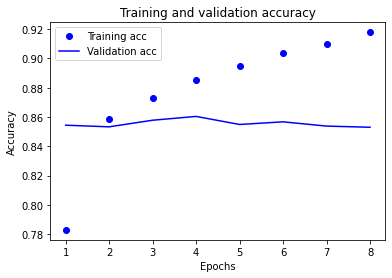

In [23]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [24]:
# 테스트셋을 통한 모델 평가
rnn_results = rnn_model.evaluate(X_test_pre,  y_test, verbose=2)
print(rnn_results)

1537/1537 - 3s - loss: 0.4040 - accuracy: 0.8485
[0.40404582023620605, 0.8485465049743652]


### CNN

In [25]:
cnn_history_dict = cnn_history.history
print(cnn_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


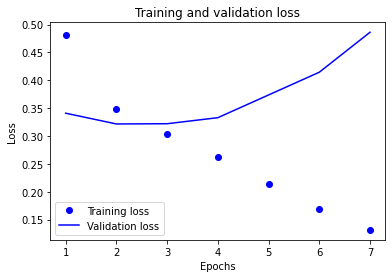

In [26]:
import matplotlib.pyplot as plt

acc = cnn_history_dict['accuracy']
val_acc = cnn_history_dict['val_accuracy']
loss = cnn_history_dict['loss']
val_loss = cnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

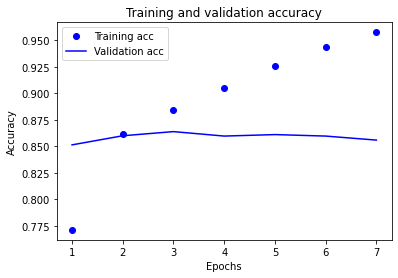

In [27]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [28]:
# 테스트셋을 통한 모델 평가
cnn_results = cnn_model.evaluate(X_test_pre, y_test, verbose=2)
print(cnn_results)

1537/1537 - 2s - loss: 0.4931 - accuracy: 0.8488
[0.493056058883667, 0.8488109707832336]


### GMP

In [29]:
gmp_history_dict = gmp_history.history
print(gmp_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


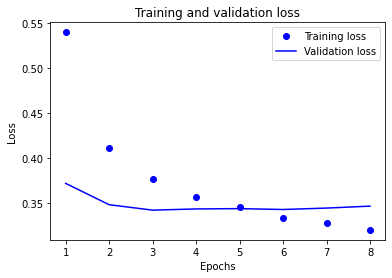

In [30]:
import matplotlib.pyplot as plt

acc = gmp_history_dict['accuracy']
val_acc = gmp_history_dict['val_accuracy']
loss = gmp_history_dict['loss']
val_loss = gmp_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

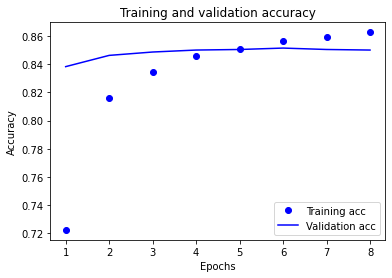

In [31]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [32]:
# 테스트셋을 통한 모델 평가
gmp_results = gmp_model.evaluate(X_test_pre, y_test, verbose=2)
print(gmp_results)

1537/1537 - 2s - loss: 0.3575 - accuracy: 0.8466
[0.35753047466278076, 0.8465732336044312]


## 모델 성능 비교

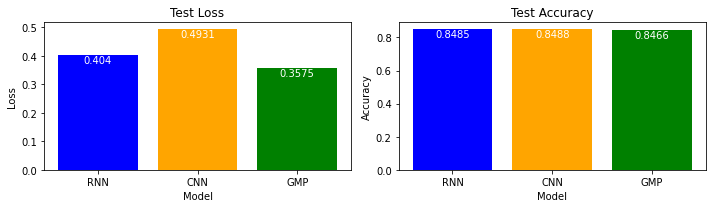

In [33]:
import matplotlib.pyplot as plt

# 각 모델의 테스트 결과 저장
results = {'RNN': rnn_results, 'CNN': cnn_results, 'GMP': gmp_results}

# 손실과 정확도 추출
losses = [result[0] for result in results.values()]
accuracies = [result[1] for result in results.values()]

# 시각화
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.bar(results.keys(), losses, color=['blue', 'orange', 'green'])
for i, loss in enumerate(losses):
    plt.text(i, loss, str(round(loss, 4)), ha='center', va='top', color='white')
plt.title('Test Loss')
plt.xlabel('Model')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.bar(results.keys(), accuracies, color=['blue', 'orange', 'green'])
for i, acc in enumerate(accuracies):
    plt.text(i, acc, str(round(acc, 4)), ha='center', va='top', color='white')
plt.title('Test Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


### 모델별 성능 분석
세 개의 모델이 모두 84% 후반대의 정확도를 나타낸다. 세 모델 모두 Word2Vec Embedding Layer를 적용해보자.

## 7) 학습된 Embedding 레이어 분석

In [34]:
rnn_embedding_layer = rnn_model.layers[0]
rnn_weights = rnn_embedding_layer.get_weights()[0]
print(rnn_weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [35]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
file_path = os.getenv('HOME')+'/aiffel/NLP/sentiment_classification/data/rnn_embedding.txt'
f = open(file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = rnn_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [36]:
from gensim.models import KeyedVectors

# 저장된 단어 임베딩 파일을 로드합니다.
word_vectors = KeyedVectors.load_word2vec_format(file_path, binary=False)

In [37]:
# '배우'와 가장 유사한 단어를 찾습니다.
word_vectors.most_similar('배우', topn=10)[:-1]

[('소이현', 0.44777312874794006),
 ('찍', 0.4425896108150482),
 ('오버액션', 0.44000306725502014),
 ('멤버', 0.43827569484710693),
 ('쿵후', 0.43766841292381287),
 ('차례', 0.4359890818595886),
 ('갱', 0.4356937110424042),
 ('딱', 0.43123817443847656),
 ('황당', 0.4303208887577057)]

In [38]:
# '장르'와 가장 유사한 단어를 찾습니다.
word_vectors.most_similar('장르', topn=10)[:-1]

[('써니', 0.6440721154212952),
 ('안다면', 0.6187566518783569),
 ('데이트', 0.6171678900718689),
 ('김수미', 0.6096211075782776),
 (".'", 0.6078038811683655),
 ('레지던트', 0.607146143913269),
 ('조마조마', 0.5971746444702148),
 ('대화', 0.5867068767547607),
 ('등등', 0.5782745480537415)]

의미로 봤을 때 딱히 유사한 단어를 찾는 거 같진 않다

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선


### Word2Vec의 유사한 단어 찾는 성능 확인

In [65]:
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

In [66]:
word_vectors.wv.vectors.shape

(302960, 100)

In [67]:
word_vectors.wv.most_similar('배우')

[('가수', 0.7729029655456543),
 ('코미디언', 0.7728644609451294),
 ('만화가', 0.749615490436554),
 ('영화배우', 0.7441834211349487),
 ('여배우', 0.7411354184150696),
 ('연출가', 0.7396705746650696),
 ('극작가', 0.7209770679473877),
 ('삽화가', 0.7152643799781799),
 ('안무가', 0.7149248123168945),
 ('무용가', 0.7118033766746521)]

In [68]:
word_vectors.wv.most_similar('장르')

[('스타일', 0.7507143616676331),
 ('주제', 0.7043392658233643),
 ('멜로디', 0.6926088333129883),
 ('요소', 0.6893783807754517),
 ('사운드', 0.6872262358665466),
 ('레퍼토리', 0.6859424114227295),
 ('펑크', 0.6812448501586914),
 ('발라드', 0.6788304448127747),
 ('음악', 0.6761245727539062),
 ('사조', 0.6682040691375732)]

### 직접 학습한 모델 + Word2Vec -> 감정 분석

In [69]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

### RNN

In [70]:
# 모델 구성

from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

up_rnn_model = tf.keras.Sequential()
up_rnn_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
up_rnn_model.add(tf.keras.layers.LSTM(100))  
up_rnn_model.add(tf.keras.layers.Dropout(0.8))  # Dropout 추가
up_rnn_model.add(tf.keras.layers.Dense(64, activation='relu'))
up_rnn_model.add(tf.keras.layers.Dropout(0.8))  # Dropout 추가
up_rnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

up_rnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 54, 100)           1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 1,086,929
Trainable params: 1,086,929
Non-trainable params: 0
____________________________________________

In [71]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
up_rnn_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              

from keras.callbacks import EarlyStopping, LearningRateScheduler

epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5) 

up_rnn_history = up_rnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stop],  
                    verbose=1)

Epoch 1/30
266/266 [==============================] - 5s 13ms/step - loss: 0.6709 - accuracy: 0.5984 - val_loss: 0.5169 - val_accuracy: 0.7686
Epoch 2/30
266/266 [==============================] - 3s 11ms/step - loss: 0.4933 - accuracy: 0.7782 - val_loss: 0.3895 - val_accuracy: 0.8281
Epoch 3/30
266/266 [==============================] - 3s 11ms/step - loss: 0.4130 - accuracy: 0.8262 - val_loss: 0.3460 - val_accuracy: 0.8503
Epoch 4/30
266/266 [==============================] - 3s 12ms/step - loss: 0.3734 - accuracy: 0.8462 - val_loss: 0.3292 - val_accuracy: 0.8548
Epoch 5/30
266/266 [==============================] - 3s 11ms/step - loss: 0.3469 - accuracy: 0.8601 - val_loss: 0.3245 - val_accuracy: 0.8601
Epoch 6/30
266/266 [==============================] - 3s 11ms/step - loss: 0.3282 - accuracy: 0.8692 - val_loss: 0.3271 - val_accuracy: 0.8594
Epoch 7/30
266/266 [==============================] - 3s 11ms/step - loss: 0.3129 - accuracy: 0.8764 - val_loss: 0.3234 - val_accuracy: 0.8599

In [72]:
up_rnn_history_dict = up_rnn_history.history

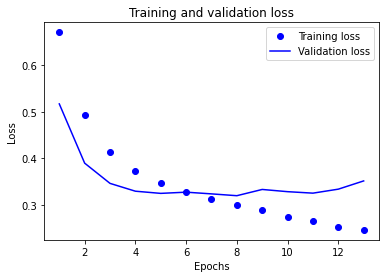

In [73]:
import matplotlib.pyplot as plt

acc = up_rnn_history_dict['accuracy']
val_acc = up_rnn_history_dict['val_accuracy']
loss = up_rnn_history_dict['loss']
val_loss = up_rnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

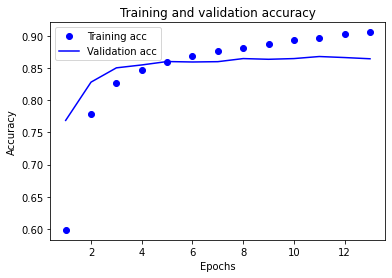

In [74]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [75]:
# 테스트셋을 통한 모델 평가
up_rnn_results = up_rnn_model.evaluate(X_test_pre,  y_test, verbose=2)
print(up_rnn_results)

1537/1537 - 3s - loss: 0.3602 - accuracy: 0.8613
[0.3601764440536499, 0.8613422513008118]


### CNN

In [76]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [77]:
# 모델 구성

from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

up_cnn_model = tf.keras.Sequential()
up_cnn_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
up_cnn_model.add(tf.keras.layers.Conv1D(64, 5, activation='relu'))
up_cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
up_cnn_model.add(tf.keras.layers.Dense(32, activation='relu'))
up_cnn_model.add(tf.keras.layers.Dropout(0.7))  # 드롭아웃 적용
up_cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

up_cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 54, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 64)            32064     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 1,034,177
Trainable params: 1,034,177
Non-trainable params: 0
____________________________________________

In [78]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
up_cnn_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              

from keras.callbacks import EarlyStopping, LearningRateScheduler

epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5) 

up_cnn_history = up_cnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stop],  
                    verbose=1)

Epoch 1/30
266/266 [==============================] - 2s 7ms/step - loss: 0.7322 - accuracy: 0.5683 - val_loss: 0.5648 - val_accuracy: 0.7169
Epoch 2/30
266/266 [==============================] - 2s 6ms/step - loss: 0.5834 - accuracy: 0.6849 - val_loss: 0.5052 - val_accuracy: 0.7680
Epoch 3/30
266/266 [==============================] - 2s 6ms/step - loss: 0.5225 - accuracy: 0.7396 - val_loss: 0.4349 - val_accuracy: 0.8023
Epoch 4/30
266/266 [==============================] - 2s 6ms/step - loss: 0.4646 - accuracy: 0.7775 - val_loss: 0.3929 - val_accuracy: 0.8249
Epoch 5/30
266/266 [==============================] - 2s 6ms/step - loss: 0.4217 - accuracy: 0.8037 - val_loss: 0.3708 - val_accuracy: 0.8368
Epoch 6/30
266/266 [==============================] - 2s 6ms/step - loss: 0.3891 - accuracy: 0.8252 - val_loss: 0.3599 - val_accuracy: 0.8417
Epoch 7/30
266/266 [==============================] - 2s 6ms/step - loss: 0.3676 - accuracy: 0.8398 - val_loss: 0.3528 - val_accuracy: 0.8470
Epoch 

In [79]:
up_cnn_history_dict = up_cnn_history.history

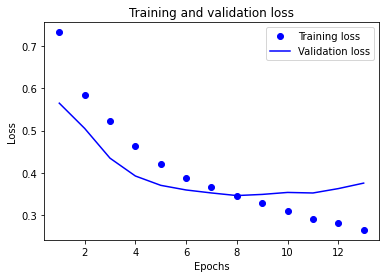

In [80]:
import matplotlib.pyplot as plt

acc = up_cnn_history_dict['accuracy']
val_acc = up_cnn_history_dict['val_accuracy']
loss = up_cnn_history_dict['loss']
val_loss = up_cnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

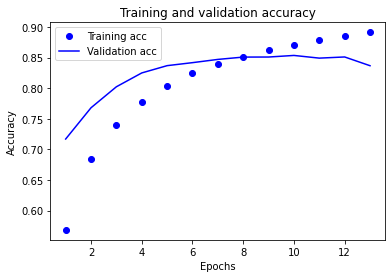

In [81]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [82]:
# 테스트셋을 통한 모델 평가
up_cnn_results = up_cnn_model.evaluate(X_test_pre,  y_test, verbose=2)
print(up_cnn_results)

1537/1537 - 2s - loss: 0.3828 - accuracy: 0.8369
[0.3827892243862152, 0.8368899822235107]


### GMP

In [83]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [84]:
# 모델 구성

from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

up_gmp_model = tf.keras.Sequential()
up_gmp_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
up_gmp_model.add(tf.keras.layers.GlobalMaxPooling1D())
up_gmp_model.add(tf.keras.layers.Dropout(0.7))  # 드롭아웃 레이어 추가
up_gmp_model.add(tf.keras.layers.Dense(64, activation='relu'))
up_gmp_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

up_gmp_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 54, 100)           1000000   
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 100)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 1,006,529
Trainable params: 1,006,529
Non-trainable params: 0
_________________________________________________________________


In [85]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
up_gmp_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              

from keras.callbacks import EarlyStopping, LearningRateScheduler

epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5) 

up_gmp_history = up_gmp_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stop],  
                    verbose=1)

Epoch 1/30
266/266 [==============================] - 2s 5ms/step - loss: 0.9415 - accuracy: 0.5117 - val_loss: 0.6829 - val_accuracy: 0.5400
Epoch 2/30
266/266 [==============================] - 1s 4ms/step - loss: 0.7071 - accuracy: 0.5286 - val_loss: 0.6836 - val_accuracy: 0.5313
Epoch 3/30
266/266 [==============================] - 1s 4ms/step - loss: 0.6927 - accuracy: 0.5397 - val_loss: 0.6778 - val_accuracy: 0.6001
Epoch 4/30
266/266 [==============================] - 1s 4ms/step - loss: 0.6887 - accuracy: 0.5463 - val_loss: 0.6777 - val_accuracy: 0.5646
Epoch 5/30
266/266 [==============================] - 1s 4ms/step - loss: 0.6870 - accuracy: 0.5508 - val_loss: 0.6726 - val_accuracy: 0.5995
Epoch 6/30
266/266 [==============================] - 1s 4ms/step - loss: 0.6840 - accuracy: 0.5566 - val_loss: 0.6768 - val_accuracy: 0.5356
Epoch 7/30
266/266 [==============================] - 1s 4ms/step - loss: 0.6810 - accuracy: 0.5651 - val_loss: 0.6637 - val_accuracy: 0.6757
Epoch 

In [86]:
up_gmp_history_dict = up_gmp_history.history

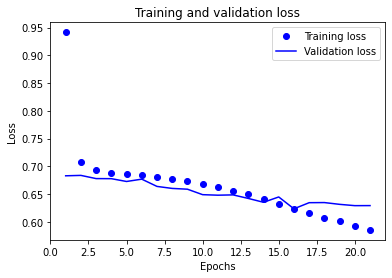

In [87]:
import matplotlib.pyplot as plt

acc = up_gmp_history_dict['accuracy']
val_acc = up_gmp_history_dict['val_accuracy']
loss = up_gmp_history_dict['loss']
val_loss = up_gmp_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

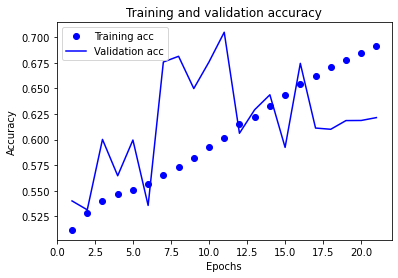

In [88]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [89]:
# 테스트셋을 통한 모델 평가
up_gmp_results = up_gmp_model.evaluate(X_test_pre,  y_test, verbose=2)
print(up_gmp_results)

1537/1537 - 2s - loss: 0.6299 - accuracy: 0.6222
[0.6298578977584839, 0.6221901178359985]


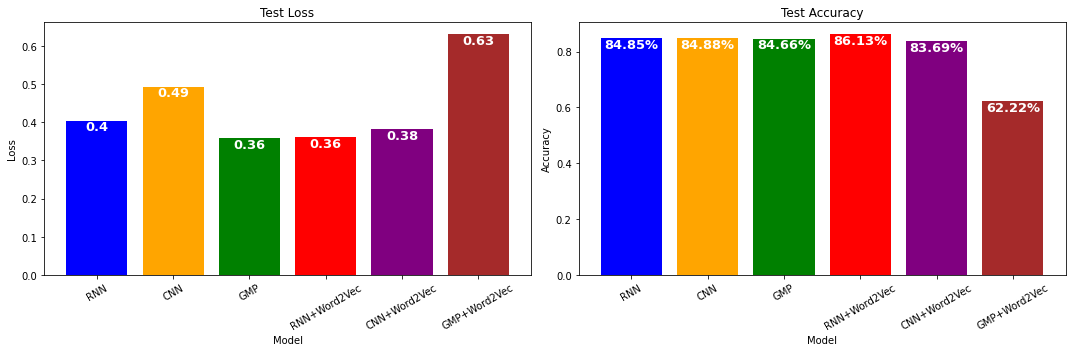

In [96]:
import matplotlib.pyplot as plt

# 각 모델의 테스트 결과 저장
results = {'RNN': rnn_results, 'CNN': cnn_results, 'GMP': gmp_results, 
           'RNN+Word2Vec': up_rnn_results, 'CNN+Word2Vec': up_cnn_results, 'GMP+Word2Vec': up_gmp_results}

# 손실과 정확도 추출
losses = [result[0] for result in results.values()]
accuracies = [result[1] for result in results.values()]

# 색상 리스트
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(results.keys(), losses, color=colors)
for i, loss in enumerate(losses):
    plt.text(i, loss, str(round(loss, 2)), ha='center', va='top', color='white', fontweight='heavy', fontsize=13)
plt.xticks(rotation=30)
plt.title('Test Loss')
plt.xlabel('Model')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.bar(results.keys(), accuracies, color=colors)
for i, acc in enumerate(accuracies):
    plt.text(i, acc, str(round(acc*100, 2))+'%', ha='center', va='top', color='white', fontweight='heavy', fontsize=13)
plt.xticks(rotation=30)
plt.title('Test Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

### 모델 성능 평가
결과: RNN model에 사전학습된 Word2Vec Embedding layer를 추가하니 86.13%의 성능을 달성했다.

의문점: Global Max Pooling 모델에 Word2Vec Embedding layer를 추가했을 때는 왜 성능이 떨어지는지 의문이 든다...
모든 모델에서 배운 방법을 사용해도 과대적합이 일어나는데 이를 해결할 방법에 대해 좀 더 고민해야겠다.
Word2Vec를 사용한다고 해서 눈에 띄는 성능 향상이 일어나지 않는 것 또한 의문이다.